# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)
NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8719
Epoch 1/200, Iteration 2/12, Loss: 0.7995
Epoch 1/200, Iteration 3/12, Loss: 1.3924
Epoch 1/200, Iteration 4/12, Loss: 0.9896
Epoch 1/200, Iteration 5/12, Loss: 0.7748
Epoch 1/200, Iteration 6/12, Loss: 0.4060
Epoch 1/200, Iteration 7/12, Loss: 0.5806
Epoch 1/200, Iteration 8/12, Loss: 0.4060
Epoch 1/200, Iteration 9/12, Loss: 0.4951
Epoch 1/200, Iteration 10/12, Loss: 0.5196
Epoch 1/200, Iteration 11/12, Loss: 0.4505
Epoch 1/200, Iteration 12/12, Loss: 0.3435
Epoch 1/200, Iteration 13/12, Loss: 0.5321
Epoch 1/200, Iteration 1/12, Loss: 0.8719
Epoch 1/200, Iteration 2/12, Loss: 0.7995
Epoch 1/200, Iteration 3/12, Loss: 1.3924
Epoch 1/200, Iteration 4/12, Loss: 0.9896
Epoch 1/200, Iteration 5/12, Loss: 0.7748
Epoch 1/200, Iteration 6/12, Loss: 0.4060
Epoch 1/200, Iteration 7/12, Loss: 0.5806
Epoch 1/200, Iteration 8/12, Loss: 0.4060
Epoch 1/200, Iteration 9/12, Loss: 0.4951
Epoch 1/200, Iteration 10/12, Loss: 0.5196
Epoch 1/200, Iteration 11/12,

Train Error: 
 Accuracy: 85.88%, Avg loss: 0.159894, MRE: 0.113174, MAE: 0.021368 

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.140853, MRE: 0.093427, MAE: 0.018541 

Epoch 7/200, Iteration 1/12, Loss: 0.1662
Epoch 7/200, Iteration 2/12, Loss: 0.1350
Epoch 7/200, Iteration 3/12, Loss: 0.1469
Epoch 7/200, Iteration 4/12, Loss: 0.1904
Epoch 7/200, Iteration 5/12, Loss: 0.1557
Epoch 7/200, Iteration 6/12, Loss: 0.1933
Epoch 7/200, Iteration 7/12, Loss: 0.2348
Epoch 7/200, Iteration 8/12, Loss: 0.2101
Epoch 7/200, Iteration 9/12, Loss: 0.2526
Epoch 7/200, Iteration 10/12, Loss: 0.1794
Epoch 7/200, Iteration 11/12, Loss: 0.1717
Epoch 7/200, Iteration 12/12, Loss: 0.1822
Epoch 7/200, Iteration 13/12, Loss: 0.1715
Train Error: 
 Accuracy: 85.88%, Avg loss: 0.159894, MRE: 0.113174, MAE: 0.021368 

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.140853, MRE: 0.093427, MAE: 0.018541 

Epoch 7/200, Iteration 1/12, Loss: 0.1662
Epoch 7/200, Iteration 2/12, Loss: 0.1350
Epoch 7/200, Iteration 3/12, Loss:

Train Error: 
 Accuracy: 60.38%, Avg loss: 0.111911, MRE: 0.128180, MAE: 0.014253 

Test Error: 
 Accuracy: 64.5%, Avg loss: 0.094631, MRE: 0.094593, MAE: 0.011945 

Epoch 13/200, Iteration 1/12, Loss: 0.0992
Epoch 13/200, Iteration 2/12, Loss: 0.1287
Epoch 13/200, Iteration 3/12, Loss: 0.1583
Epoch 13/200, Iteration 4/12, Loss: 0.1449
Epoch 13/200, Iteration 5/12, Loss: 0.0948
Epoch 13/200, Iteration 6/12, Loss: 0.1345
Epoch 13/200, Iteration 7/12, Loss: 0.1626
Epoch 13/200, Iteration 8/12, Loss: 0.1391
Epoch 13/200, Iteration 9/12, Loss: 0.1606
Epoch 13/200, Iteration 10/12, Loss: 0.1426
Epoch 13/200, Iteration 11/12, Loss: 0.1265
Epoch 13/200, Iteration 12/12, Loss: 0.1249
Epoch 13/200, Iteration 13/12, Loss: 0.1084
Train Error: 
 Accuracy: 60.38%, Avg loss: 0.111911, MRE: 0.128180, MAE: 0.014253 

Test Error: 
 Accuracy: 64.5%, Avg loss: 0.094631, MRE: 0.094593, MAE: 0.011945 

Epoch 13/200, Iteration 1/12, Loss: 0.0992
Epoch 13/200, Iteration 2/12, Loss: 0.1287
Epoch 13/200, Itera

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.063877, MRE: 0.039148, MAE: 0.008541 

Epoch 19/200, Iteration 1/12, Loss: 0.0615
Epoch 19/200, Iteration 2/12, Loss: 0.0916
Epoch 19/200, Iteration 3/12, Loss: 0.1055
Epoch 19/200, Iteration 4/12, Loss: 0.0894
Epoch 19/200, Iteration 5/12, Loss: 0.0820
Epoch 19/200, Iteration 6/12, Loss: 0.0620
Epoch 19/200, Iteration 7/12, Loss: 0.0620
Epoch 19/200, Iteration 8/12, Loss: 0.0598
Epoch 19/200, Iteration 9/12, Loss: 0.0831
Epoch 19/200, Iteration 10/12, Loss: 0.0951
Epoch 19/200, Iteration 11/12, Loss: 0.0707
Epoch 19/200, Iteration 12/12, Loss: 0.0803
Epoch 19/200, Iteration 13/12, Loss: 0.0751
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.089230, MRE: 0.067915, MAE: 0.011124 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.075395, MRE: 0.051608, MAE: 0.009259 

Epoch 20/200, Iteration 1/12, Loss: 0.0855
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.063877, MRE: 0.039148, MAE: 0.008541 

Epoch 19/200, Iteration 1/12, Loss: 0.0615
Epoch 19/200, Iterati

Train Error: 
 Accuracy: 74.88%, Avg loss: 0.124389, MRE: 0.128448, MAE: 0.015786 

Test Error: 
 Accuracy: 82.0%, Avg loss: 0.110775, MRE: 0.098801, MAE: 0.013680 

Epoch 25/200, Iteration 1/12, Loss: 0.1141
Epoch 25/200, Iteration 2/12, Loss: 0.1265
Epoch 25/200, Iteration 3/12, Loss: 0.0995
Epoch 25/200, Iteration 4/12, Loss: 0.0928
Epoch 25/200, Iteration 5/12, Loss: 0.0852
Epoch 25/200, Iteration 6/12, Loss: 0.1021
Epoch 25/200, Iteration 7/12, Loss: 0.0853
Epoch 25/200, Iteration 8/12, Loss: 0.0795
Epoch 25/200, Iteration 9/12, Loss: 0.0979
Epoch 25/200, Iteration 10/12, Loss: 0.0872
Epoch 25/200, Iteration 11/12, Loss: 0.1238
Epoch 25/200, Iteration 12/12, Loss: 0.0740
Epoch 25/200, Iteration 13/12, Loss: 0.1540
Train Error: 
 Accuracy: 74.88%, Avg loss: 0.124389, MRE: 0.128448, MAE: 0.015786 

Test Error: 
 Accuracy: 82.0%, Avg loss: 0.110775, MRE: 0.098801, MAE: 0.013680 

Epoch 25/200, Iteration 1/12, Loss: 0.1141
Epoch 25/200, Iteration 2/12, Loss: 0.1265
Epoch 25/200, Itera

Epoch 30/200, Iteration 8/12, Loss: 0.0619
Epoch 30/200, Iteration 9/12, Loss: 0.0718
Epoch 30/200, Iteration 10/12, Loss: 0.0659
Epoch 30/200, Iteration 11/12, Loss: 0.0601
Epoch 30/200, Iteration 12/12, Loss: 0.0660
Epoch 30/200, Iteration 13/12, Loss: 0.0513
Train Error: 
 Accuracy: 94.88%, Avg loss: 0.048239, MRE: 0.044922, MAE: 0.006480 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.046031, MRE: 0.029520, MAE: 0.006168 

Epoch 31/200, Iteration 1/12, Loss: 0.0430
Epoch 31/200, Iteration 2/12, Loss: 0.0507
Epoch 31/200, Iteration 3/12, Loss: 0.0441
Epoch 31/200, Iteration 4/12, Loss: 0.0582
Epoch 31/200, Iteration 5/12, Loss: 0.0595
Epoch 31/200, Iteration 6/12, Loss: 0.0564
Epoch 31/200, Iteration 7/12, Loss: 0.0532
Epoch 31/200, Iteration 8/12, Loss: 0.0480
Epoch 30/200, Iteration 8/12, Loss: 0.0619
Epoch 30/200, Iteration 9/12, Loss: 0.0718
Epoch 30/200, Iteration 10/12, Loss: 0.0659
Epoch 30/200, Iteration 11/12, Loss: 0.0601
Epoch 30/200, Iteration 12/12, Loss: 0.0660
Epoch 30/2

Epoch 36/200, Iteration 3/12, Loss: 0.0245
Epoch 36/200, Iteration 4/12, Loss: 0.0258
Epoch 36/200, Iteration 5/12, Loss: 0.0240
Epoch 36/200, Iteration 6/12, Loss: 0.0218
Epoch 36/200, Iteration 7/12, Loss: 0.0247
Epoch 36/200, Iteration 8/12, Loss: 0.0252
Epoch 36/200, Iteration 9/12, Loss: 0.0247
Epoch 36/200, Iteration 10/12, Loss: 0.0232
Epoch 36/200, Iteration 11/12, Loss: 0.0260
Epoch 36/200, Iteration 12/12, Loss: 0.0234
Epoch 36/200, Iteration 13/12, Loss: 0.0239
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.022596, MRE: 0.025127, MAE: 0.002886 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.021997, MRE: 0.016573, MAE: 0.002853 

Epoch 37/200, Iteration 1/12, Loss: 0.0248
Epoch 37/200, Iteration 2/12, Loss: 0.0266
Epoch 37/200, Iteration 3/12, Loss: 0.0216
Epoch 37/200, Iteration 4/12, Loss: 0.0214
Epoch 37/200, Iteration 5/12, Loss: 0.0189
Epoch 37/200, Iteration 6/12, Loss: 0.0212
Epoch 37/200, Iteration 7/12, Loss: 0.0205
Epoch 37/200, Iteration 8/12, Loss: 0.0202
Epoch 37/200,

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.019649, MRE: 0.013845, MAE: 0.002645 

Epoch 42/200, Iteration 1/12, Loss: 0.0165
Epoch 42/200, Iteration 2/12, Loss: 0.0170
Epoch 42/200, Iteration 3/12, Loss: 0.0198
Epoch 42/200, Iteration 4/12, Loss: 0.0187
Epoch 42/200, Iteration 5/12, Loss: 0.0189
Epoch 42/200, Iteration 6/12, Loss: 0.0195
Epoch 42/200, Iteration 7/12, Loss: 0.0169
Epoch 42/200, Iteration 8/12, Loss: 0.0145
Epoch 42/200, Iteration 9/12, Loss: 0.0149
Epoch 42/200, Iteration 10/12, Loss: 0.0141
Epoch 42/200, Iteration 11/12, Loss: 0.0215
Epoch 42/200, Iteration 12/12, Loss: 0.0190
Epoch 42/200, Iteration 13/12, Loss: 0.0138
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.016490, MRE: 0.018107, MAE: 0.002184 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.019649, MRE: 0.013845, MAE: 0.002645 

Epoch 42/200, Iteration 1/12, Loss: 0.0165
Epoch 42/200, Iteration 2/12, Loss: 0.0170
Epoch 42/200, Iteration 3/12, Loss: 0.0198
Epoch 42/200, Iteration 4/12, Loss: 0.0187
Epoch 42/200, Ite

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.017360, MRE: 0.012839, MAE: 0.002174 

Epoch 47/200, Iteration 1/12, Loss: 0.0129
Epoch 47/200, Iteration 2/12, Loss: 0.0163
Epoch 47/200, Iteration 3/12, Loss: 0.0174
Epoch 47/200, Iteration 4/12, Loss: 0.0127
Epoch 47/200, Iteration 5/12, Loss: 0.0166
Epoch 47/200, Iteration 6/12, Loss: 0.0146
Epoch 47/200, Iteration 7/12, Loss: 0.0151
Epoch 47/200, Iteration 8/12, Loss: 0.0144
Epoch 47/200, Iteration 9/12, Loss: 0.0158
Epoch 47/200, Iteration 10/12, Loss: 0.0135
Epoch 47/200, Iteration 11/12, Loss: 0.0123
Epoch 47/200, Iteration 12/12, Loss: 0.0213
Epoch 47/200, Iteration 13/12, Loss: 0.0138
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.013974, MRE: 0.014263, MAE: 0.001815 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.015877, MRE: 0.012282, MAE: 0.002067 

Epoch 48/200, Iteration 1/12, Loss: 0.0118
Epoch 48/200, Iteration 2/12, Loss: 0.0140
Epoch 48/200, Iteration 3/12, Loss: 0.0142
Epoch 48/200, Iteration 4/12, Loss: 0.0126
Epoch 48/200, Ite

Epoch 52/200, Iteration 12/12, Loss: 0.0207
Epoch 52/200, Iteration 13/12, Loss: 0.0170
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.020059, MRE: 0.015118, MAE: 0.002743 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.022699, MRE: 0.014037, MAE: 0.003085 

Epoch 53/200, Iteration 1/12, Loss: 0.0185
Epoch 53/200, Iteration 2/12, Loss: 0.0166
Epoch 53/200, Iteration 3/12, Loss: 0.0200
Epoch 53/200, Iteration 4/12, Loss: 0.0178
Epoch 53/200, Iteration 5/12, Loss: 0.0187
Epoch 53/200, Iteration 6/12, Loss: 0.0203
Epoch 53/200, Iteration 7/12, Loss: 0.0157
Epoch 53/200, Iteration 8/12, Loss: 0.0132
Epoch 53/200, Iteration 9/12, Loss: 0.0151
Epoch 53/200, Iteration 10/12, Loss: 0.0137
Epoch 53/200, Iteration 11/12, Loss: 0.0129
Epoch 53/200, Iteration 12/12, Loss: 0.0123
Epoch 53/200, Iteration 13/12, Loss: 0.0122
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.012742, MRE: 0.011601, MAE: 0.001641 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015079, MRE: 0.010756, MAE: 0.001841 

Epoch 54/200, Ite

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.017652, MRE: 0.014287, MAE: 0.002441 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.017798, MRE: 0.011544, MAE: 0.002413 

Epoch 59/200, Iteration 1/12, Loss: 0.0212
Epoch 59/200, Iteration 2/12, Loss: 0.0166
Epoch 59/200, Iteration 3/12, Loss: 0.0183
Epoch 59/200, Iteration 4/12, Loss: 0.0135
Epoch 59/200, Iteration 5/12, Loss: 0.0210
Epoch 59/200, Iteration 6/12, Loss: 0.0181
Epoch 59/200, Iteration 7/12, Loss: 0.0269
Epoch 59/200, Iteration 8/12, Loss: 0.0242
Epoch 59/200, Iteration 9/12, Loss: 0.0123
Epoch 59/200, Iteration 10/12, Loss: 0.0216
Epoch 59/200, Iteration 11/12, Loss: 0.0165
Epoch 59/200, Iteration 12/12, Loss: 0.0161
Epoch 59/200, Iteration 13/12, Loss: 0.0195
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.017628, MRE: 0.014040, MAE: 0.002290 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018536, MRE: 0.012969, MAE: 0.002314 

Epoch 60/200, Iteration 1/12, Loss: 0.0179
Epoch 60/200, Iteration 2/12, Loss: 0.0173
Epoch 60/200, Itera

Epoch 65/200, Iteration 2/12, Loss: 0.0143
Epoch 65/200, Iteration 3/12, Loss: 0.0139
Epoch 65/200, Iteration 4/12, Loss: 0.0145
Epoch 65/200, Iteration 5/12, Loss: 0.0124
Epoch 65/200, Iteration 6/12, Loss: 0.0129
Epoch 65/200, Iteration 7/12, Loss: 0.0135
Epoch 65/200, Iteration 8/12, Loss: 0.0145
Epoch 65/200, Iteration 9/12, Loss: 0.0136
Epoch 65/200, Iteration 10/12, Loss: 0.0131
Epoch 65/200, Iteration 11/12, Loss: 0.0137
Epoch 65/200, Iteration 12/12, Loss: 0.0119
Epoch 65/200, Iteration 13/12, Loss: 0.0117
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.014950, MRE: 0.011343, MAE: 0.001892 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.017850, MRE: 0.011234, MAE: 0.002166 

Epoch 66/200, Iteration 1/12, Loss: 0.0130
Epoch 66/200, Iteration 2/12, Loss: 0.0174
Epoch 66/200, Iteration 3/12, Loss: 0.0114
Epoch 66/200, Iteration 4/12, Loss: 0.0138
Epoch 66/200, Iteration 5/12, Loss: 0.0183
Epoch 66/200, Iteration 6/12, Loss: 0.0109
Epoch 66/200, Iteration 7/12, Loss: 0.0133
Epoch 66/200,

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.016693, MRE: 0.012605, MAE: 0.002190 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.018476, MRE: 0.012108, MAE: 0.002378 

Epoch 71/200, Iteration 1/12, Loss: 0.0160
Epoch 71/200, Iteration 2/12, Loss: 0.0130
Epoch 71/200, Iteration 3/12, Loss: 0.0208
Epoch 71/200, Iteration 4/12, Loss: 0.0152
Epoch 71/200, Iteration 5/12, Loss: 0.0145
Epoch 71/200, Iteration 6/12, Loss: 0.0124
Epoch 71/200, Iteration 7/12, Loss: 0.0123
Epoch 71/200, Iteration 8/12, Loss: 0.0145
Epoch 71/200, Iteration 9/12, Loss: 0.0117
Epoch 71/200, Iteration 10/12, Loss: 0.0145
Epoch 71/200, Iteration 11/12, Loss: 0.0145
Epoch 71/200, Iteration 12/12, Loss: 0.0117
Epoch 71/200, Iteration 13/12, Loss: 0.0171
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.014589, MRE: 0.011057, MAE: 0.002028 

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.016693, MRE: 0.012605, MAE: 0.002190 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.018476, MRE: 0.012108, MAE: 0.002378 

Epoch 71/200, Iterati

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.009939, MRE: 0.009005, MAE: 0.001310 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.011377, MRE: 0.007554, MAE: 0.001487 

Epoch 77/200, Iteration 1/12, Loss: 0.0094
Epoch 77/200, Iteration 2/12, Loss: 0.0083
Epoch 77/200, Iteration 3/12, Loss: 0.0120
Epoch 77/200, Iteration 4/12, Loss: 0.0092
Epoch 77/200, Iteration 5/12, Loss: 0.0080
Epoch 77/200, Iteration 6/12, Loss: 0.0091
Epoch 77/200, Iteration 7/12, Loss: 0.0075
Epoch 77/200, Iteration 8/12, Loss: 0.0090
Epoch 77/200, Iteration 9/12, Loss: 0.0079
Epoch 77/200, Iteration 10/12, Loss: 0.0096
Epoch 77/200, Iteration 11/12, Loss: 0.0075
Epoch 77/200, Iteration 12/12, Loss: 0.0069
Epoch 77/200, Iteration 13/12, Loss: 0.0134
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.009939, MRE: 0.009005, MAE: 0.001310 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.011377, MRE: 0.007554, MAE: 0.001487 

Epoch 77/200, Iteration 1/12, Loss: 0.0094
Epoch 77/200, Iteration 2/12, Loss: 0.0083
Epoch 77/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005915, MRE: 0.006104, MAE: 0.000772 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008909, MRE: 0.006301, MAE: 0.001110 

Epoch 83/200, Iteration 1/12, Loss: 0.0057
Epoch 83/200, Iteration 2/12, Loss: 0.0090
Epoch 83/200, Iteration 3/12, Loss: 0.0055
Epoch 83/200, Iteration 4/12, Loss: 0.0049
Epoch 83/200, Iteration 5/12, Loss: 0.0061
Epoch 83/200, Iteration 6/12, Loss: 0.0057
Epoch 83/200, Iteration 7/12, Loss: 0.0050
Epoch 83/200, Iteration 8/12, Loss: 0.0060
Epoch 83/200, Iteration 9/12, Loss: 0.0061
Epoch 83/200, Iteration 10/12, Loss: 0.0061
Epoch 83/200, Iteration 11/12, Loss: 0.0077
Epoch 83/200, Iteration 12/12, Loss: 0.0049
Epoch 83/200, Iteration 13/12, Loss: 0.0051
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006001, MRE: 0.005985, MAE: 0.000776 

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005915, MRE: 0.006104, MAE: 0.000772 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008909, MRE: 0.006301, MAE: 0.001110 

Epoch 83/200, Iterati

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005502, MRE: 0.005512, MAE: 0.000719 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008542, MRE: 0.006034, MAE: 0.001068 

Epoch 89/200, Iteration 1/12, Loss: 0.0080
Epoch 89/200, Iteration 2/12, Loss: 0.0052
Epoch 89/200, Iteration 3/12, Loss: 0.0055
Epoch 89/200, Iteration 4/12, Loss: 0.0056
Epoch 89/200, Iteration 5/12, Loss: 0.0058
Epoch 89/200, Iteration 6/12, Loss: 0.0061
Epoch 89/200, Iteration 7/12, Loss: 0.0048
Epoch 89/200, Iteration 8/12, Loss: 0.0049
Epoch 89/200, Iteration 9/12, Loss: 0.0042
Epoch 89/200, Iteration 10/12, Loss: 0.0066
Epoch 89/200, Iteration 11/12, Loss: 0.0048
Epoch 89/200, Iteration 12/12, Loss: 0.0055
Epoch 89/200, Iteration 13/12, Loss: 0.0060
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005486, MRE: 0.005626, MAE: 0.000724 

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005502, MRE: 0.005512, MAE: 0.000719 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008542, MRE: 0.006034, MAE: 0.001068 

Epoch 89/200, Iterati

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008403, MRE: 0.005915, MAE: 0.001061 

Epoch 95/200, Iteration 1/12, Loss: 0.0043
Epoch 95/200, Iteration 2/12, Loss: 0.0048
Epoch 95/200, Iteration 3/12, Loss: 0.0038
Epoch 95/200, Iteration 4/12, Loss: 0.0053
Epoch 95/200, Iteration 5/12, Loss: 0.0053
Epoch 95/200, Iteration 6/12, Loss: 0.0048
Epoch 95/200, Iteration 7/12, Loss: 0.0075
Epoch 95/200, Iteration 8/12, Loss: 0.0051
Epoch 95/200, Iteration 9/12, Loss: 0.0064
Epoch 95/200, Iteration 10/12, Loss: 0.0059
Epoch 95/200, Iteration 11/12, Loss: 0.0055
Epoch 95/200, Iteration 12/12, Loss: 0.0048
Epoch 95/200, Iteration 13/12, Loss: 0.0099
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005454, MRE: 0.005639, MAE: 0.000703 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008438, MRE: 0.005995, MAE: 0.001057 

Epoch 96/200, Iteration 1/12, Loss: 0.0047
Epoch 96/200, Iteration 2/12, Loss: 0.0055
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008403, MRE: 0.005915, MAE: 0.001061 

Epoch 95/200, Iterati

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005108, MRE: 0.005361, MAE: 0.000671 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008232, MRE: 0.005836, MAE: 0.001028 

Epoch 101/200, Iteration 1/12, Loss: 0.0050
Epoch 101/200, Iteration 2/12, Loss: 0.0048
Epoch 101/200, Iteration 3/12, Loss: 0.0040
Epoch 101/200, Iteration 4/12, Loss: 0.0043
Epoch 101/200, Iteration 5/12, Loss: 0.0071
Epoch 101/200, Iteration 6/12, Loss: 0.0070
Epoch 101/200, Iteration 7/12, Loss: 0.0045
Epoch 101/200, Iteration 8/12, Loss: 0.0058
Epoch 101/200, Iteration 9/12, Loss: 0.0070
Epoch 101/200, Iteration 10/12, Loss: 0.0047
Epoch 101/200, Iteration 11/12, Loss: 0.0051
Epoch 101/200, Iteration 12/12, Loss: 0.0040
Epoch 101/200, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005108, MRE: 0.005361, MAE: 0.000671 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008232, MRE: 0.005836, MAE: 0.001028 

Epoch 101/200, Iteration 1/12, Loss: 0.0050
Epoch 101/200, Iteration 2/12, Loss: 0.0048
Epoc

Epoch 106/200, Iteration 6/12, Loss: 0.0059
Epoch 106/200, Iteration 7/12, Loss: 0.0043
Epoch 106/200, Iteration 8/12, Loss: 0.0068
Epoch 106/200, Iteration 9/12, Loss: 0.0046
Epoch 106/200, Iteration 10/12, Loss: 0.0048
Epoch 106/200, Iteration 11/12, Loss: 0.0076
Epoch 106/200, Iteration 12/12, Loss: 0.0049
Epoch 106/200, Iteration 13/12, Loss: 0.0064
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005448, MRE: 0.005453, MAE: 0.000694 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008133, MRE: 0.005785, MAE: 0.001015 

Epoch 107/200, Iteration 1/12, Loss: 0.0046
Epoch 107/200, Iteration 2/12, Loss: 0.0060
Epoch 107/200, Iteration 3/12, Loss: 0.0057
Epoch 107/200, Iteration 4/12, Loss: 0.0050
Epoch 107/200, Iteration 5/12, Loss: 0.0071
Epoch 107/200, Iteration 6/12, Loss: 0.0049
Epoch 107/200, Iteration 7/12, Loss: 0.0059
Epoch 107/200, Iteration 8/12, Loss: 0.0066
Epoch 107/200, Iteration 9/12, Loss: 0.0043
Epoch 107/200, Iteration 10/12, Loss: 0.0047
Epoch 107/200, Iteration 11/12, Loss:

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004963, MRE: 0.005206, MAE: 0.000650 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007919, MRE: 0.005720, MAE: 0.000996 

Epoch 113/200, Iteration 1/12, Loss: 0.0062
Epoch 113/200, Iteration 2/12, Loss: 0.0068
Epoch 113/200, Iteration 3/12, Loss: 0.0045
Epoch 113/200, Iteration 4/12, Loss: 0.0055
Epoch 113/200, Iteration 5/12, Loss: 0.0040
Epoch 113/200, Iteration 6/12, Loss: 0.0046
Epoch 113/200, Iteration 7/12, Loss: 0.0044
Epoch 113/200, Iteration 8/12, Loss: 0.0038
Epoch 113/200, Iteration 9/12, Loss: 0.0045
Epoch 113/200, Iteration 10/12, Loss: 0.0050
Epoch 113/200, Iteration 11/12, Loss: 0.0062
Epoch 113/200, Iteration 12/12, Loss: 0.0052
Epoch 113/200, Iteration 13/12, Loss: 0.0059
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005160, MRE: 0.005463, MAE: 0.000669 

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004963, MRE: 0.005206, MAE: 0.000650 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007919, MRE: 0.005720, MAE: 0.000996 

Epoch 11

Epoch 118/200, Iteration 3/12, Loss: 0.0045
Epoch 118/200, Iteration 4/12, Loss: 0.0049
Epoch 118/200, Iteration 5/12, Loss: 0.0043
Epoch 118/200, Iteration 6/12, Loss: 0.0086
Epoch 118/200, Iteration 7/12, Loss: 0.0058
Epoch 118/200, Iteration 8/12, Loss: 0.0042
Epoch 118/200, Iteration 9/12, Loss: 0.0052
Epoch 118/200, Iteration 10/12, Loss: 0.0061
Epoch 118/200, Iteration 11/12, Loss: 0.0053
Epoch 118/200, Iteration 12/12, Loss: 0.0046
Epoch 118/200, Iteration 13/12, Loss: 0.0092
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004910, MRE: 0.005227, MAE: 0.000643 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007880, MRE: 0.005610, MAE: 0.000982 

Epoch 119/200, Iteration 1/12, Loss: 0.0044
Epoch 119/200, Iteration 2/12, Loss: 0.0049
Epoch 119/200, Iteration 3/12, Loss: 0.0044
Epoch 119/200, Iteration 4/12, Loss: 0.0053
Epoch 119/200, Iteration 5/12, Loss: 0.0046
Epoch 119/200, Iteration 6/12, Loss: 0.0070
Epoch 119/200, Iteration 7/12, Loss: 0.0043
Epoch 119/200, Iteration 8/12, Loss: 0

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004414, MRE: 0.004875, MAE: 0.000581 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007675, MRE: 0.005507, MAE: 0.000963 

Epoch 124/200, Iteration 1/12, Loss: 0.0059
Epoch 124/200, Iteration 2/12, Loss: 0.0038
Epoch 124/200, Iteration 3/12, Loss: 0.0041
Epoch 124/200, Iteration 4/12, Loss: 0.0040
Epoch 124/200, Iteration 5/12, Loss: 0.0045
Epoch 124/200, Iteration 6/12, Loss: 0.0045
Epoch 124/200, Iteration 7/12, Loss: 0.0051
Epoch 124/200, Iteration 8/12, Loss: 0.0048
Epoch 124/200, Iteration 9/12, Loss: 0.0062
Epoch 124/200, Iteration 10/12, Loss: 0.0044
Epoch 124/200, Iteration 11/12, Loss: 0.0032
Epoch 124/200, Iteration 12/12, Loss: 0.0036
Epoch 124/200, Iteration 13/12, Loss: 0.0035
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004372, MRE: 0.004823, MAE: 0.000576 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007724, MRE: 0.005519, MAE: 0.000968 

Epoch 125/200, Iteration 1/12, Loss: 0.0058
Epoch 125/200, Iteration 2/12, Loss: 0.0039
Epoc

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004319, MRE: 0.004765, MAE: 0.000570 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007678, MRE: 0.005496, MAE: 0.000964 

Epoch 130/200, Iteration 1/12, Loss: 0.0038
Epoch 130/200, Iteration 2/12, Loss: 0.0038
Epoch 130/200, Iteration 3/12, Loss: 0.0040
Epoch 130/200, Iteration 4/12, Loss: 0.0036
Epoch 130/200, Iteration 5/12, Loss: 0.0035
Epoch 130/200, Iteration 6/12, Loss: 0.0052
Epoch 130/200, Iteration 7/12, Loss: 0.0037
Epoch 130/200, Iteration 8/12, Loss: 0.0034
Epoch 130/200, Iteration 9/12, Loss: 0.0058
Epoch 130/200, Iteration 10/12, Loss: 0.0058
Epoch 130/200, Iteration 11/12, Loss: 0.0041
Epoch 130/200, Iteration 12/12, Loss: 0.0034
Epoch 130/200, Iteration 13/12, Loss: 0.0094
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004357, MRE: 0.004845, MAE: 0.000575 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007685, MRE: 0.005494, MAE: 0.000965 

Epoch 131/200, Iteration 1/12, Loss: 0.0051
Epoch 131/200, Iteration 2/12, Loss: 0.0062
Epoc

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007651, MRE: 0.005478, MAE: 0.000961 

Epoch 136/200, Iteration 1/12, Loss: 0.0036
Epoch 136/200, Iteration 2/12, Loss: 0.0045
Epoch 136/200, Iteration 3/12, Loss: 0.0036
Epoch 136/200, Iteration 4/12, Loss: 0.0056
Epoch 136/200, Iteration 5/12, Loss: 0.0037
Epoch 136/200, Iteration 6/12, Loss: 0.0035
Epoch 136/200, Iteration 7/12, Loss: 0.0057
Epoch 136/200, Iteration 8/12, Loss: 0.0044
Epoch 136/200, Iteration 9/12, Loss: 0.0047
Epoch 136/200, Iteration 10/12, Loss: 0.0037
Epoch 136/200, Iteration 11/12, Loss: 0.0048
Epoch 136/200, Iteration 12/12, Loss: 0.0044
Epoch 136/200, Iteration 13/12, Loss: 0.0041
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004369, MRE: 0.004799, MAE: 0.000576 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007651, MRE: 0.005478, MAE: 0.000961 

Epoch 136/200, Iteration 1/12, Loss: 0.0036
Epoch 136/200, Iteration 2/12, Loss: 0.0045
Epoch 136/200, Iteration 3/12, Loss: 0.0036
Epoch 136/200, Iteration 4/12, Loss: 0.0056


Epoch 141/200, Iteration 7/12, Loss: 0.0076
Epoch 141/200, Iteration 8/12, Loss: 0.0040
Epoch 141/200, Iteration 9/12, Loss: 0.0035
Epoch 141/200, Iteration 10/12, Loss: 0.0041
Epoch 141/200, Iteration 11/12, Loss: 0.0053
Epoch 141/200, Iteration 12/12, Loss: 0.0034
Epoch 141/200, Iteration 13/12, Loss: 0.0030
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004257, MRE: 0.004731, MAE: 0.000561 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007651, MRE: 0.005472, MAE: 0.000963 

Epoch 142/200, Iteration 1/12, Loss: 0.0035
Epoch 142/200, Iteration 2/12, Loss: 0.0043
Epoch 142/200, Iteration 3/12, Loss: 0.0039
Epoch 142/200, Iteration 4/12, Loss: 0.0057
Epoch 142/200, Iteration 5/12, Loss: 0.0039
Epoch 142/200, Iteration 6/12, Loss: 0.0038
Epoch 142/200, Iteration 7/12, Loss: 0.0036
Epoch 142/200, Iteration 8/12, Loss: 0.0059
Epoch 142/200, Iteration 9/12, Loss: 0.0038
Epoch 142/200, Iteration 10/12, Loss: 0.0053
Epoch 142/200, Iteration 11/12, Loss: 0.0041
Epoch 142/200, Iteration 12/12, Loss

Epoch 148/200, Iteration 2/12, Loss: 0.0034
Epoch 148/200, Iteration 3/12, Loss: 0.0041
Epoch 148/200, Iteration 4/12, Loss: 0.0047
Epoch 148/200, Iteration 5/12, Loss: 0.0066
Epoch 148/200, Iteration 6/12, Loss: 0.0038
Epoch 148/200, Iteration 7/12, Loss: 0.0040
Epoch 148/200, Iteration 8/12, Loss: 0.0060
Epoch 148/200, Iteration 9/12, Loss: 0.0038
Epoch 148/200, Iteration 10/12, Loss: 0.0040
Epoch 148/200, Iteration 11/12, Loss: 0.0045
Epoch 148/200, Iteration 12/12, Loss: 0.0034
Epoch 148/200, Iteration 13/12, Loss: 0.0032
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004261, MRE: 0.004730, MAE: 0.000562 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007619, MRE: 0.005436, MAE: 0.000959 

Epoch 149/200, Iteration 1/12, Loss: 0.0043
Epoch 149/200, Iteration 2/12, Loss: 0.0044
Epoch 149/200, Iteration 3/12, Loss: 0.0037
Epoch 149/200, Iteration 4/12, Loss: 0.0039
Epoch 149/200, Iteration 5/12, Loss: 0.0037
Epoch 149/200, Iteration 6/12, Loss: 0.0079
Epoch 149/200, Iteration 7/12, Loss: 0

Epoch 153/200, Iteration 6/12, Loss: 0.0038
Epoch 153/200, Iteration 7/12, Loss: 0.0037
Epoch 153/200, Iteration 8/12, Loss: 0.0035
Epoch 153/200, Iteration 9/12, Loss: 0.0058
Epoch 153/200, Iteration 10/12, Loss: 0.0056
Epoch 153/200, Iteration 11/12, Loss: 0.0038
Epoch 153/200, Iteration 12/12, Loss: 0.0050
Epoch 153/200, Iteration 13/12, Loss: 0.0031
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004224, MRE: 0.004684, MAE: 0.000557 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007594, MRE: 0.005411, MAE: 0.000956 

Epoch 154/200, Iteration 1/12, Loss: 0.0038
Epoch 154/200, Iteration 2/12, Loss: 0.0056
Epoch 154/200, Iteration 3/12, Loss: 0.0040
Epoch 154/200, Iteration 4/12, Loss: 0.0061
Epoch 154/200, Iteration 5/12, Loss: 0.0040
Epoch 154/200, Iteration 6/12, Loss: 0.0037
Epoch 154/200, Iteration 7/12, Loss: 0.0036
Epoch 154/200, Iteration 8/12, Loss: 0.0038
Epoch 154/200, Iteration 9/12, Loss: 0.0038
Epoch 154/200, Iteration 10/12, Loss: 0.0048
Epoch 154/200, Iteration 11/12, Loss:

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007573, MRE: 0.005393, MAE: 0.000954 

Epoch 160/200, Iteration 1/12, Loss: 0.0044
Epoch 160/200, Iteration 2/12, Loss: 0.0046
Epoch 160/200, Iteration 3/12, Loss: 0.0040
Epoch 160/200, Iteration 4/12, Loss: 0.0037
Epoch 160/200, Iteration 5/12, Loss: 0.0036
Epoch 160/200, Iteration 6/12, Loss: 0.0061
Epoch 160/200, Iteration 7/12, Loss: 0.0046
Epoch 160/200, Iteration 8/12, Loss: 0.0036
Epoch 160/200, Iteration 9/12, Loss: 0.0037
Epoch 160/200, Iteration 10/12, Loss: 0.0034
Epoch 160/200, Iteration 11/12, Loss: 0.0037
Epoch 160/200, Iteration 12/12, Loss: 0.0037
Epoch 160/200, Iteration 13/12, Loss: 0.0084
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004185, MRE: 0.004657, MAE: 0.000550 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007573, MRE: 0.005393, MAE: 0.000954 

Epoch 160/200, Iteration 1/12, Loss: 0.0044
Epoch 160/200, Iteration 2/12, Loss: 0.0046
Epoch 160/200, Iteration 3/12, Loss: 0.0040
Epoch 160/200, Iteration 4/12, Loss: 0.0037


Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007595, MRE: 0.005391, MAE: 0.000955 

Epoch 165/200, Iteration 1/12, Loss: 0.0034
Epoch 165/200, Iteration 2/12, Loss: 0.0030
Epoch 165/200, Iteration 3/12, Loss: 0.0046
Epoch 165/200, Iteration 4/12, Loss: 0.0036
Epoch 165/200, Iteration 5/12, Loss: 0.0045
Epoch 165/200, Iteration 6/12, Loss: 0.0066
Epoch 165/200, Iteration 7/12, Loss: 0.0034
Epoch 165/200, Iteration 8/12, Loss: 0.0040
Epoch 165/200, Iteration 9/12, Loss: 0.0032
Epoch 165/200, Iteration 10/12, Loss: 0.0052
Epoch 165/200, Iteration 11/12, Loss: 0.0053
Epoch 165/200, Iteration 12/12, Loss: 0.0046
Epoch 165/200, Iteration 13/12, Loss: 0.0034
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004175, MRE: 0.004645, MAE: 0.000549 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007569, MRE: 0.005384, MAE: 0.000954 

Epoch 166/200, Iteration 1/12, Loss: 0.0038
Epoch 166/200, Iteration 2/12, Loss: 0.0040
Epoch 166/200, Iteration 3/12, Loss: 0.0039
Epoch 166/200, Iteration 4/12, Loss: 0.0037


Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004161, MRE: 0.004664, MAE: 0.000548 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007556, MRE: 0.005397, MAE: 0.000950 

Epoch 171/200, Iteration 1/12, Loss: 0.0041
Epoch 171/200, Iteration 2/12, Loss: 0.0032
Epoch 171/200, Iteration 3/12, Loss: 0.0039
Epoch 171/200, Iteration 4/12, Loss: 0.0036
Epoch 171/200, Iteration 5/12, Loss: 0.0042
Epoch 171/200, Iteration 6/12, Loss: 0.0038
Epoch 171/200, Iteration 7/12, Loss: 0.0041
Epoch 171/200, Iteration 8/12, Loss: 0.0046
Epoch 171/200, Iteration 9/12, Loss: 0.0058
Epoch 171/200, Iteration 10/12, Loss: 0.0041
Epoch 171/200, Iteration 11/12, Loss: 0.0059
Epoch 171/200, Iteration 12/12, Loss: 0.0036
Epoch 171/200, Iteration 13/12, Loss: 0.0037
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004189, MRE: 0.004655, MAE: 0.000551 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007525, MRE: 0.005376, MAE: 0.000947 

Epoch 172/200, Iteration 1/12, Loss: 0.0036
Epoch 172/200, Iteration 2/12, Loss: 0.0034
Epoc

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004171, MRE: 0.004634, MAE: 0.000550 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007520, MRE: 0.005368, MAE: 0.000948 

Epoch 177/200, Iteration 1/12, Loss: 0.0036
Epoch 177/200, Iteration 2/12, Loss: 0.0034
Epoch 177/200, Iteration 3/12, Loss: 0.0035
Epoch 177/200, Iteration 4/12, Loss: 0.0032
Epoch 177/200, Iteration 5/12, Loss: 0.0049
Epoch 177/200, Iteration 6/12, Loss: 0.0067
Epoch 177/200, Iteration 7/12, Loss: 0.0044
Epoch 177/200, Iteration 8/12, Loss: 0.0037
Epoch 177/200, Iteration 9/12, Loss: 0.0065
Epoch 177/200, Iteration 10/12, Loss: 0.0041
Epoch 177/200, Iteration 11/12, Loss: 0.0040
Epoch 177/200, Iteration 12/12, Loss: 0.0033
Epoch 177/200, Iteration 13/12, Loss: 0.0040
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004252, MRE: 0.004654, MAE: 0.000559 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007611, MRE: 0.005404, MAE: 0.000961 

Epoch 178/200, Iteration 1/12, Loss: 0.0036
Epoch 178/200, Iteration 2/12, Loss: 0.0036
Epoc

Epoch 183/200, Iteration 3/12, Loss: 0.0039
Epoch 183/200, Iteration 4/12, Loss: 0.0057
Epoch 183/200, Iteration 5/12, Loss: 0.0037
Epoch 183/200, Iteration 6/12, Loss: 0.0049
Epoch 183/200, Iteration 7/12, Loss: 0.0037
Epoch 183/200, Iteration 8/12, Loss: 0.0052
Epoch 183/200, Iteration 9/12, Loss: 0.0043
Epoch 183/200, Iteration 10/12, Loss: 0.0030
Epoch 183/200, Iteration 11/12, Loss: 0.0033
Epoch 183/200, Iteration 12/12, Loss: 0.0053
Epoch 183/200, Iteration 13/12, Loss: 0.0032
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004126, MRE: 0.004636, MAE: 0.000543 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007534, MRE: 0.005359, MAE: 0.000949 

Epoch 184/200, Iteration 1/12, Loss: 0.0040
Epoch 184/200, Iteration 2/12, Loss: 0.0038
Epoch 184/200, Iteration 3/12, Loss: 0.0049
Epoch 184/200, Iteration 4/12, Loss: 0.0043
Epoch 184/200, Iteration 5/12, Loss: 0.0037
Epoch 184/200, Iteration 6/12, Loss: 0.0033
Epoch 183/200, Iteration 3/12, Loss: 0.0039
Epoch 183/200, Iteration 4/12, Loss: 0

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004107, MRE: 0.004594, MAE: 0.000541 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007523, MRE: 0.005353, MAE: 0.000948 

Epoch 189/200, Iteration 1/12, Loss: 0.0044
Epoch 189/200, Iteration 2/12, Loss: 0.0044
Epoch 189/200, Iteration 3/12, Loss: 0.0035
Epoch 189/200, Iteration 4/12, Loss: 0.0037
Epoch 189/200, Iteration 5/12, Loss: 0.0050
Epoch 189/200, Iteration 6/12, Loss: 0.0032
Epoch 189/200, Iteration 7/12, Loss: 0.0054
Epoch 189/200, Iteration 8/12, Loss: 0.0036
Epoch 189/200, Iteration 9/12, Loss: 0.0039
Epoch 189/200, Iteration 10/12, Loss: 0.0039
Epoch 189/200, Iteration 11/12, Loss: 0.0038
Epoch 189/200, Iteration 12/12, Loss: 0.0040
Epoch 189/200, Iteration 13/12, Loss: 0.0058
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004107, MRE: 0.004594, MAE: 0.000541 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007523, MRE: 0.005353, MAE: 0.000948 

Epoch 189/200, Iteration 1/12, Loss: 0.0044
Epoch 189/200, Iteration 2/12, Loss: 0.0044
Epoc

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004104, MRE: 0.004639, MAE: 0.000541 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007524, MRE: 0.005354, MAE: 0.000948 

Epoch 195/200, Iteration 1/12, Loss: 0.0032
Epoch 195/200, Iteration 2/12, Loss: 0.0036
Epoch 195/200, Iteration 3/12, Loss: 0.0033
Epoch 195/200, Iteration 4/12, Loss: 0.0045
Epoch 195/200, Iteration 5/12, Loss: 0.0054
Epoch 195/200, Iteration 6/12, Loss: 0.0065
Epoch 195/200, Iteration 7/12, Loss: 0.0045
Epoch 195/200, Iteration 8/12, Loss: 0.0043
Epoch 195/200, Iteration 9/12, Loss: 0.0029
Epoch 195/200, Iteration 10/12, Loss: 0.0037
Epoch 195/200, Iteration 11/12, Loss: 0.0032
Epoch 195/200, Iteration 12/12, Loss: 0.0044
Epoch 195/200, Iteration 13/12, Loss: 0.0042
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004097, MRE: 0.004564, MAE: 0.000541 

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004104, MRE: 0.004639, MAE: 0.000541 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007524, MRE: 0.005354, MAE: 0.000948 

Epoch 19

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004269, MRE: 0.004691, MAE: 0.000558 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007524, MRE: 0.005353, MAE: 0.000948 

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004269, MRE: 0.004691, MAE: 0.000558 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007524, MRE: 0.005353, MAE: 0.000948 



#### Plots loss vs Epoch

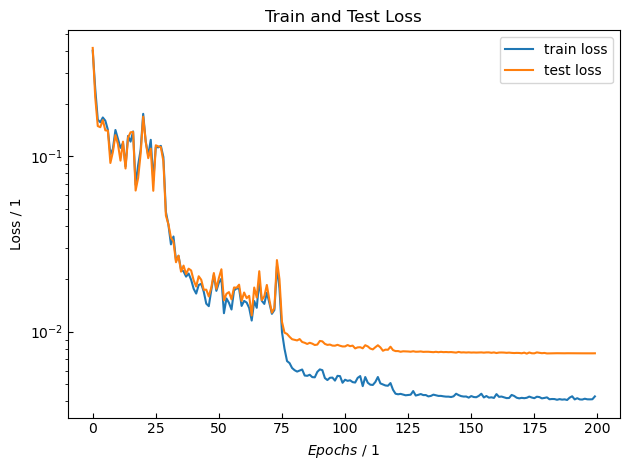

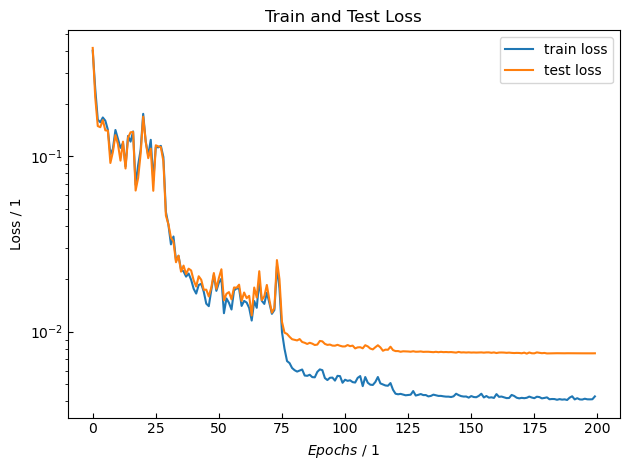

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9998773870823606 , R^2(NH3) = 0.9998370849657888
Test Dataset: R^2(H2) = 0.9999138202877733 , R^2(NH3) = 0.999787329842262
Max Error Training: |x_H2 - x_H2,pred| = 0.049461882402839774 , |x_NH3 - x_NH3,pred| = 0.02242321673207437
Max Error Test: |x_H2 - x_H2,pred| = 0.006295265976684283 , |x_NH3 - x_NH3,pred| = 0.01130050653730974
Training Dataset: R^2(H2) = 0.9998773870823606 , R^2(NH3) = 0.9998370849657888
Test Dataset: R^2(H2) = 0.9999138202877733 , R^2(NH3) = 0.999787329842262
Max Error Training: |x_H2 - x_H2,pred| = 0.049461882402839774 , |x_NH3 - x_NH3,pred| = 0.02242321673207437
Max Error Test: |x_H2 - x_H2,pred| = 0.006295265976684283 , |x_NH3 - x_NH3,pred| = 0.01130050653730974


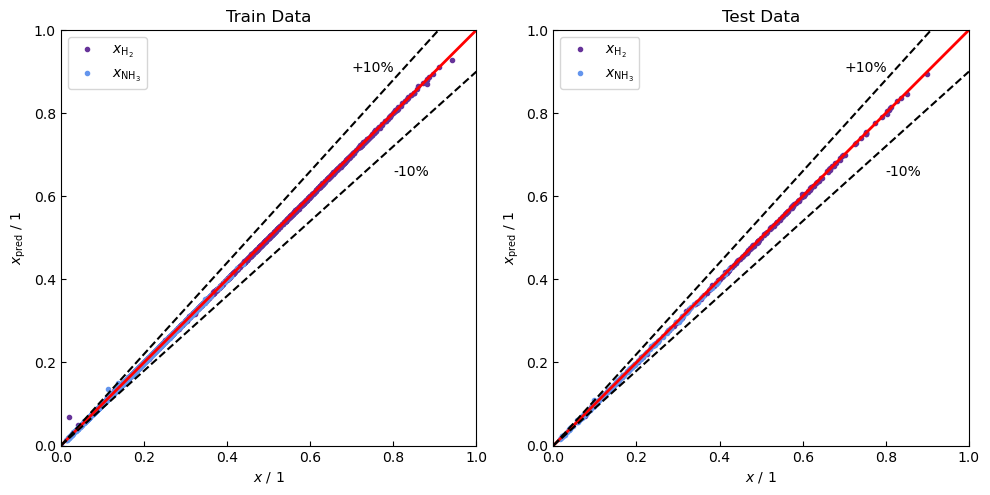

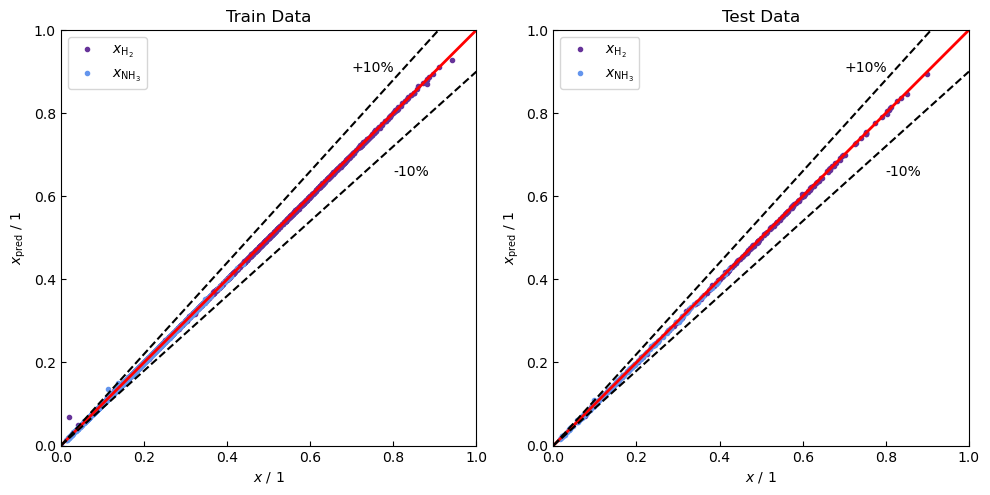

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

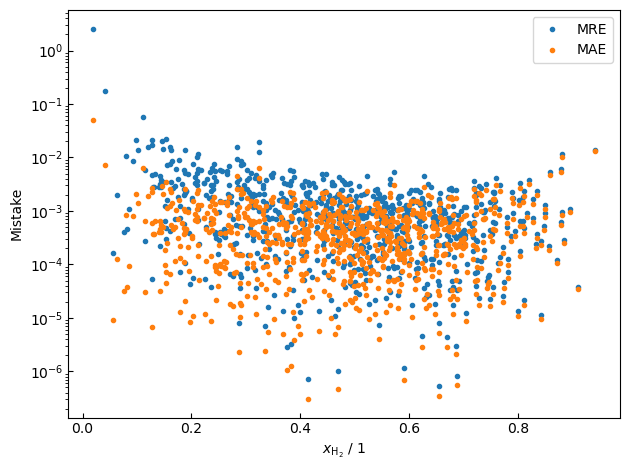

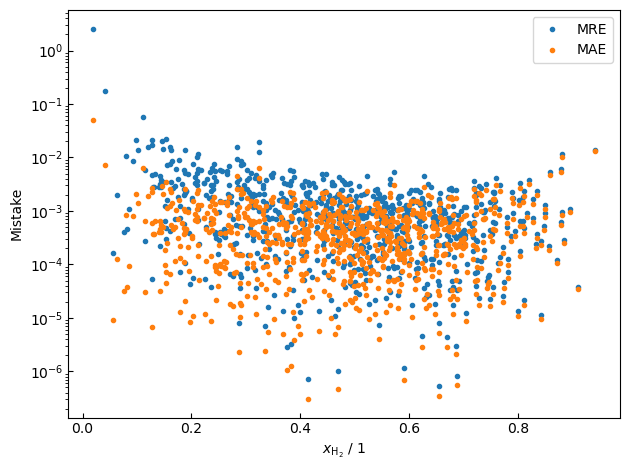

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

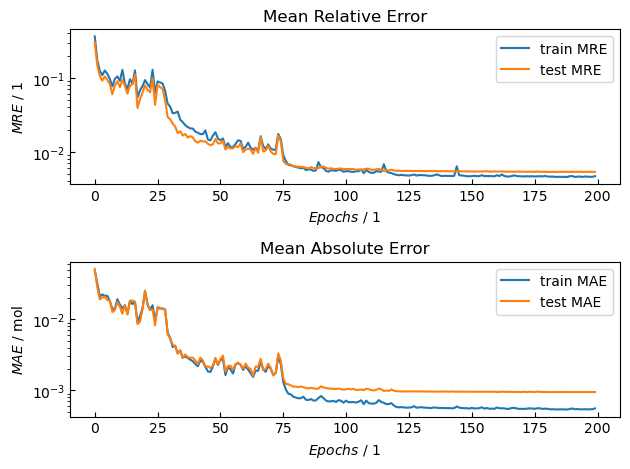

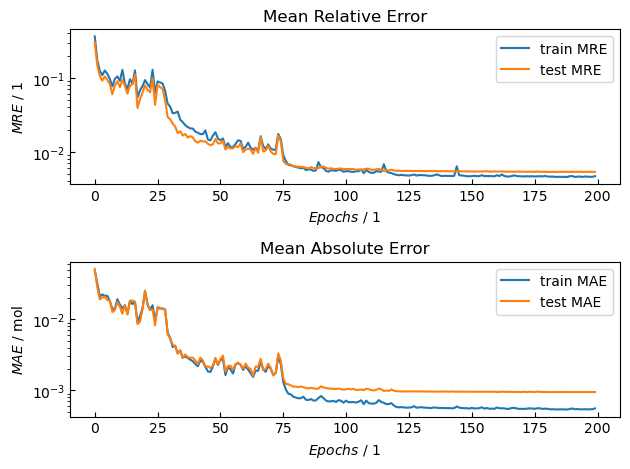

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

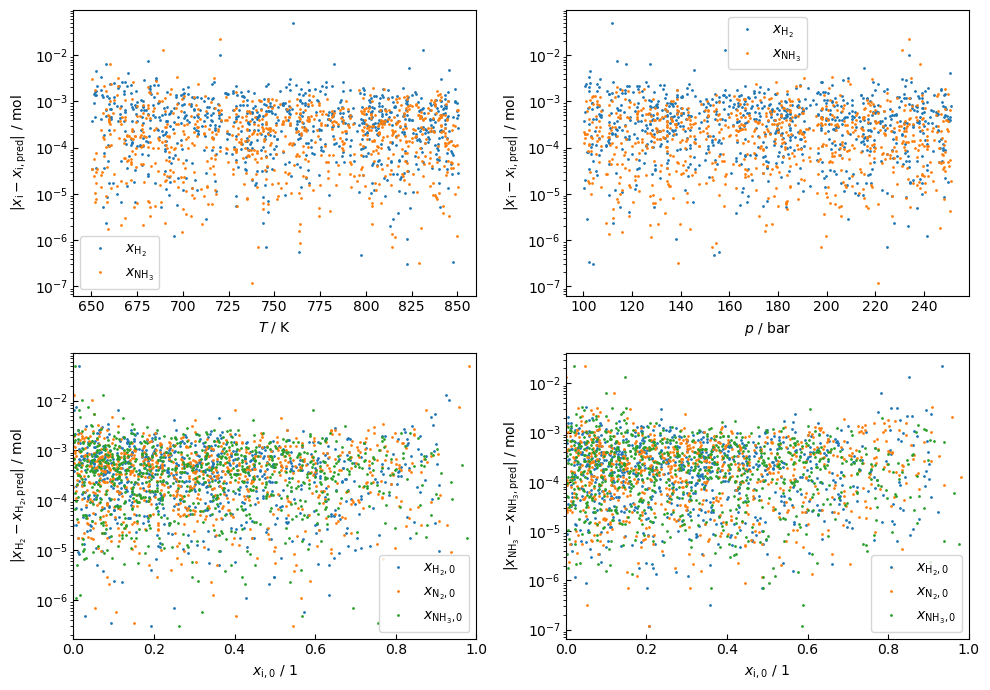

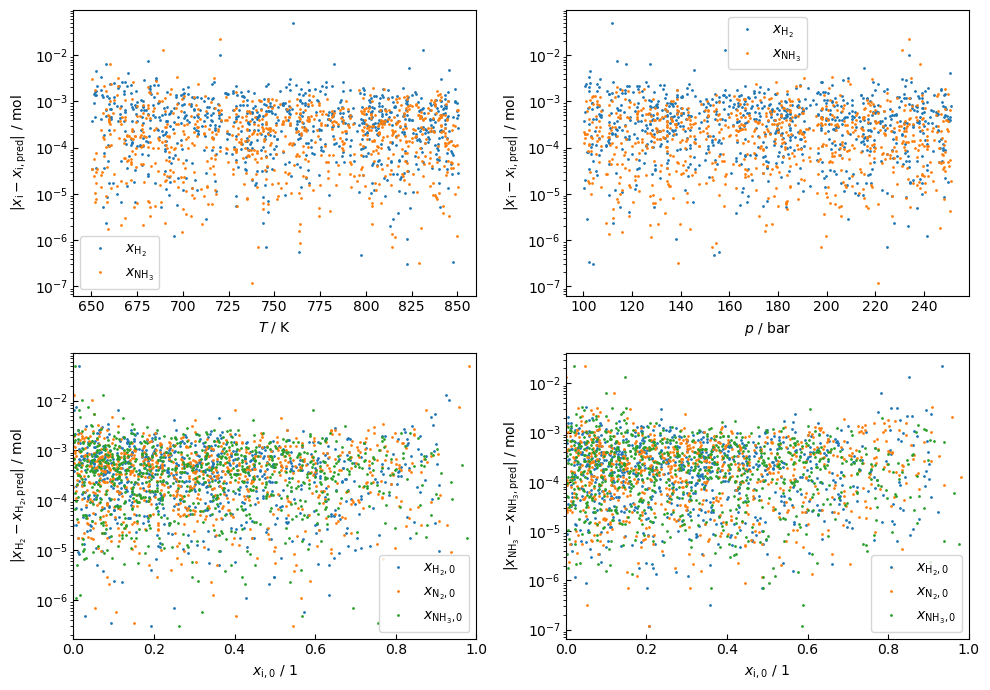

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

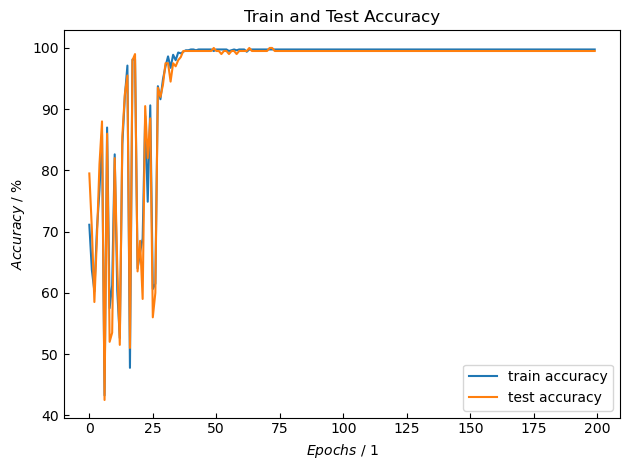

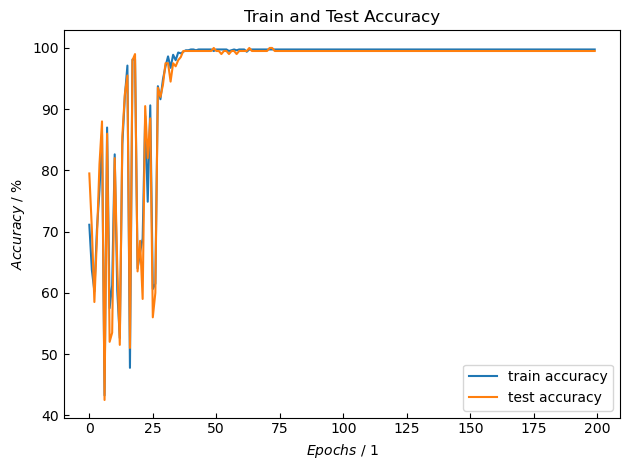

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 8.8372e-01,  1.0953e+00,  4.3870e-02, -1.2372e+00,  1.2215e+00],
        [ 1.1893e+00, -4.1034e-01, -8.3780e-01,  2.0083e+00, -1.2305e+00],
        [ 4.5679e-01,  9.5400e-01, -1.0174e+00,  5.9541e-02,  9.3759e-01],
        [ 8.3992e-01, -7.6941e-01,  1.4998e+00, -3.1671e-01, -1.1482e+00],
        [-1.6187e+00,  1.1109e+00,  8.8883e-01,  3.8476e-01, -1.2655e+00],
        [-1.2011e+00,  6.9819e-01,  6.7602e-01,  6.2887e-01, -1.3062e+00],
        [-4.1436e-01,  1.0392e+00,  2.8921e-01, -2.7491e-01, -2.8432e-03],
        [-1.3888e+00, -1.8914e-01,  1.3511e+00, -3.2221e-01, -9.9661e-01],
        [-6.5081e-01,  1.3536e+00,  2.1032e+00, -1.2638e+00, -7.7232e-01],
        [ 1.4589e+00, -1.5676e+00, -1.3017e+00, -1.6596e-01,  1.4471e+00],
        [ 1.4930e+00, -5.7002e-01, -4.0104e-01,  3.4526e-02,  3.5829e-01],
        [ 1.1987e+00, -9.1626e-01, -8.9835e-01, -1.3440e+00,  2.2553e+00],
        [-6.0833e-02, -5.6901e-01,  2.3399e+00, -1.0071e+00, -1.2670e+00],
        [-6.0781e-01, -1.

tensor([[ 8.8372e-01,  1.0953e+00,  4.3870e-02, -1.2372e+00,  1.2215e+00],
        [ 1.1893e+00, -4.1034e-01, -8.3780e-01,  2.0083e+00, -1.2305e+00],
        [ 4.5679e-01,  9.5400e-01, -1.0174e+00,  5.9541e-02,  9.3759e-01],
        [ 8.3992e-01, -7.6941e-01,  1.4998e+00, -3.1671e-01, -1.1482e+00],
        [-1.6187e+00,  1.1109e+00,  8.8883e-01,  3.8476e-01, -1.2655e+00],
        [-1.2011e+00,  6.9819e-01,  6.7602e-01,  6.2887e-01, -1.3062e+00],
        [-4.1436e-01,  1.0392e+00,  2.8921e-01, -2.7491e-01, -2.8432e-03],
        [-1.3888e+00, -1.8914e-01,  1.3511e+00, -3.2221e-01, -9.9661e-01],
        [-6.5081e-01,  1.3536e+00,  2.1032e+00, -1.2638e+00, -7.7232e-01],
        [ 1.4589e+00, -1.5676e+00, -1.3017e+00, -1.6596e-01,  1.4471e+00],
        [ 1.4930e+00, -5.7002e-01, -4.0104e-01,  3.4526e-02,  3.5829e-01],
        [ 1.1987e+00, -9.1626e-01, -8.9835e-01, -1.3440e+00,  2.2553e+00],
        [-6.0833e-02, -5.6901e-01,  2.3399e+00, -1.0071e+00, -1.2670e+00],
        [-6.0781e-01, -1.

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-0.0280,  0.0784, -0.0757, -0.3840, -0.1879],
         [-0.1954,  0.0848, -0.0388,  0.2115,  0.0423],
         [-0.3271, -0.1632, -0.0644,  0.4101,  0.1899],
         [-0.2757, -0.1082, -0.2595,  0.2582, -0.3447],
         [ 0.2510, -0.0887, -0.3237,  0.1689, -0.1911],
         [ 0.3031, -0.1796,  0.2290, -0.2083,  0.1622],
         [ 0.0463,  0.1296, -0.3410, -0.0388, -0.1835],
         [ 0.1471, -0.0661,  0.2662,  0.3595,  0.2965],
         [ 0.1803,  0.0629,  0.4499,  0.1547,  0.0950],
         [ 0.2928,  0.0680,  0.3460,  0.1760,  0.3224],
         [-0.3556, -0.4858, -0.0638, -0.0234,  0.2402],
         [-0.2556, -0.0568,  0.4498, -0.3251, -0.1877],
         [ 0.0317, -0.0255, -0.1193,  0.2098, -0.1855],
         [-0.3563,  0.3011, -0.1903,  0.3332,  0.0995],
         [ 0.3292,  0.2810, -0.2003,  0.0180, -0.3952],
         [ 0.3261, -0.3072, -0.0838, -0.1453, -0.2314],
         [ 0.0705, -0.0465,  0.2476,  0.2487,  0.2142],
         [ 0.0121, -0.216

[Parameter containing:
 tensor([[-0.0280,  0.0784, -0.0757, -0.3840, -0.1879],
         [-0.1954,  0.0848, -0.0388,  0.2115,  0.0423],
         [-0.3271, -0.1632, -0.0644,  0.4101,  0.1899],
         [-0.2757, -0.1082, -0.2595,  0.2582, -0.3447],
         [ 0.2510, -0.0887, -0.3237,  0.1689, -0.1911],
         [ 0.3031, -0.1796,  0.2290, -0.2083,  0.1622],
         [ 0.0463,  0.1296, -0.3410, -0.0388, -0.1835],
         [ 0.1471, -0.0661,  0.2662,  0.3595,  0.2965],
         [ 0.1803,  0.0629,  0.4499,  0.1547,  0.0950],
         [ 0.2928,  0.0680,  0.3460,  0.1760,  0.3224],
         [-0.3556, -0.4858, -0.0638, -0.0234,  0.2402],
         [-0.2556, -0.0568,  0.4498, -0.3251, -0.1877],
         [ 0.0317, -0.0255, -0.1193,  0.2098, -0.1855],
         [-0.3563,  0.3011, -0.1903,  0.3332,  0.0995],
         [ 0.3292,  0.2810, -0.2003,  0.0180, -0.3952],
         [ 0.3261, -0.3072, -0.0838, -0.1453, -0.2314],
         [ 0.0705, -0.0465,  0.2476,  0.2487,  0.2142],
         [ 0.0121, -0.216

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.0086, 0.1548, 0.2149, 0.4818, 0.0059],
        [0.8679, 0.5807, 0.1578, 0.9013, 0.5755]])
tensor([[-0.2303,  0.0120],
        [-0.1318, -0.5491]], grad_fn=<AddmmBackward0>)
tensor([[0.0086, 0.1548, 0.2149, 0.4818, 0.0059],
        [0.8679, 0.5807, 0.1578, 0.9013, 0.5755]])
tensor([[-0.2303,  0.0120],
        [-0.1318, -0.5491]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-0.6428, -0.1032, -0.9699,  0.3975,  0.5456],
        [ 0.8680, -0.6359,  1.4197, -0.0272, -1.3655],
        [ 1.3533,  0.7942,  0.4791, -0.8365,  0.3848],
        [ 0.0491, -0.1389,  2.1761, -1.2780, -0.8294],
        [ 0.0647,  0.5565, -1.2876,  0.9926,  0.2492],
        [ 1.3365,  0.8808, -0.9499, -0.3153,  1.2544],
        [ 0.4837,  1.2219,  1.3520, -1.0786, -0.2244],
        [ 1.0097,  0.7578,  0.7107, -0.5220, -0.1639],
        [-0.1693,  1.4109, -0.4863, -1.1455,  1.6481],
        [ 1.0246, -1.2166,  0.0151, -1.3600,  1.3752],
        [-0.8278,  1.3647, -0.5390,  1.3985, -0.9005],
        [-1.3394, -1.6039,  1.2570, -0.5473, -0.6741],
        [-0.0869,  1.5931,  0.4977, -0.2679, -0.2146],
        [ 0.1564,  0.0046, -0.5625, -1.2557,  1.8354],
        [-0.2806, -0.8661,  0.6571, -0.5221, -0.1112],
        [ 0.8707,  1.0656, -0.7654, -0.2625,  1.0195],
        [-1.0372,  1.1801, -0.5317, -0.1352,  0.6600],
        [ 0.7465,  1.4261, -1.0118, -0.0505,  1.0446],
        [ 

tensor([[-0.6428, -0.1032, -0.9699,  0.3975,  0.5456],
        [ 0.8680, -0.6359,  1.4197, -0.0272, -1.3655],
        [ 1.3533,  0.7942,  0.4791, -0.8365,  0.3848],
        [ 0.0491, -0.1389,  2.1761, -1.2780, -0.8294],
        [ 0.0647,  0.5565, -1.2876,  0.9926,  0.2492],
        [ 1.3365,  0.8808, -0.9499, -0.3153,  1.2544],
        [ 0.4837,  1.2219,  1.3520, -1.0786, -0.2244],
        [ 1.0097,  0.7578,  0.7107, -0.5220, -0.1639],
        [-0.1693,  1.4109, -0.4863, -1.1455,  1.6481],
        [ 1.0246, -1.2166,  0.0151, -1.3600,  1.3752],
        [-0.8278,  1.3647, -0.5390,  1.3985, -0.9005],
        [-1.3394, -1.6039,  1.2570, -0.5473, -0.6741],
        [-0.0869,  1.5931,  0.4977, -0.2679, -0.2146],
        [ 0.1564,  0.0046, -0.5625, -1.2557,  1.8354],
        [-0.2806, -0.8661,  0.6571, -0.5221, -0.1112],
        [ 0.8707,  1.0656, -0.7654, -0.2625,  1.0195],
        [-1.0372,  1.1801, -0.5317, -0.1352,  0.6600],
        [ 0.7465,  1.4261, -1.0118, -0.0505,  1.0446],
        [ 

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()